# <font color='teal'>Pro Football Reference Combine Data Extraction</font>

In [1]:
# Import packages
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd
from datetime import datetime
import time
import os

In [2]:
# Website base
# 'https://www.pro-football-reference.com/draft/2020-combine.htm'
combine_site_base = 'https://www.pro-football-reference.com/draft/'
years = 10
latest_year = 2020
years_range = (latest_year - years + 1, latest_year)
target_player = 'D.K. Metcalf'
# This string needs to match exactly as spelled on pro-football-reference

In [3]:
# Positions by role
positions_all = ['OL', 'DL', 'RB', 'WR', 'CB', 'TE', 'LB', 'K', 'S',
                 'QB', 'P', 'LS', 'OT', 'EDGE', 'FB', 'C', 'DE', 'DT',
                 'ILB', 'OLB', 'OG', 'DB', 'NT']
positions_off = ['OL', 'RB', 'WR', 'TE', 'QB', 'OT', 'FB', 'C', 'OG']
positions_def = ['DL', 'CB', 'LB', 'S', 'EDGE', 'DE', 'DT', 'ILB', 'OLB', 'DB', 'NT']
positions_spe = ['K', 'P', 'LS']

In [4]:
# Align driver
DRIVER_PATH = '\\Users\\David\\Desktop\\Python\\chromedriver\\chromedriver.exe'
driver = webdriver.Chrome(executable_path=DRIVER_PATH)

In [5]:
# Download location
downloads_folder = 'C:\\Users\\David\\Downloads'
sportsref_download_name = 'sportsref_download'

In [6]:
# Define xpaths of elements on combine site
share_dropdown_xpath = '//*[@id="all_combine"]/div[1]/div/ul/li[1]/span'
csv_download_xpath = '//*[@id="all_combine"]/div[1]/div/ul/li[1]/div/ul/li[4]/button'
xls_download_xpath = '//*[@id="all_combine"]/div[1]/div/ul/li[1]/div/ul/li[3]/button'

In [7]:
# Function to retrieve xls file from site, log time, store in dict
def combineRetriever(year, download_path, combine_site_base,
                     share_dropdown_xpath, xls_download_xpath,
                     sportsref_download_name):
    
    # Log start of loop
    loop_start_time = datetime.now()
    
    # Navigate to year's combine site
    driver.get(combine_site_base + str(year) + '-combine.htm')
    
    # Define and perform hover method
    time.sleep(2)
    action = ActionChains(driver);
    parent_level_menu = driver.find_element_by_xpath(share_dropdown_xpath)
    action.move_to_element(parent_level_menu).perform()
    time.sleep(2)
    child_level_menu = driver.find_element_by_xpath(xls_download_xpath)
    child_level_menu.click()
    time.sleep(2)
    
    # Walk os to retrieve files from Downloads folder
    onlyfiles = [f for f in os.listdir(downloads_folder) if os.path.isfile(os.path.join(downloads_folder, f))]
    
    # Filter to files having expected download name
    matching_names = []
    for file in onlyfiles:
        if sportsref_download_name in file:
            matching_names.append(file)
    
    # Add root path to file name
    full_path_matching_names = []
    for file in matching_names:
        full_path = downloads_folder + '\\' + file
        full_path_matching_names.append(full_path)
    
    # Retrieve create and modification datetimes
    # and compare if creation after latest loop start
    saved_files = []
    for f in full_path_matching_names:
        mod_time = os.path.getmtime(f)
        mod_time_dt = datetime.fromtimestamp(mod_time)
        create_time = os.path.getctime(f)
        create_time_dt = datetime.fromtimestamp(create_time)
        if create_time_dt > loop_start_time:
            saved_files.append(f)
    
    # Retrieve table from Downloads folder
    # Includes [0] tail on method because read_html()
    # method returns a tuple with a single element
    year_df = pd.read_html(saved_files[0])[0]
    
    return year_df;

In [8]:
# Loop through desired years, store dfs in dict
df_storage_dict = {}
for year in range(latest_year - years + 1, latest_year + 1):
    retrieve_df = combineRetriever(year,
                                   downloads_folder,
                                   combine_site_base,
                                   share_dropdown_xpath,
                                   xls_download_xpath,
                                   sportsref_download_name)
    retrieve_df.insert(0, 'Combine Year', int(year))
    df_storage_dict[year] = retrieve_df

In [9]:
# Concatenate to master df
master_df = pd.DataFrame()
for year in range(latest_year - years + 1, latest_year + 1):
    master_df = pd.concat([df_storage_dict[year], master_df], axis=0)

In [70]:
# Reduce df to target series: combine year, name, popsition, and 40yd
dash_df = master_df[['Combine Year', 'Player', 'Pos', '40yd']]
dash_df = dash_df.sort_values('40yd', ascending=True).reset_index()
dash_df.drop('index', axis=1, inplace=True)
dash_df.dropna(axis=0, how='any', subset=['40yd'], inplace=True)

# Identify target player (D.K. Metcalf) time and index in DataFrame
target_player_loc = dash_df[dash_df['Player'] == target_player].index[0]
target_player_speed = dash_df.iloc[target_player_loc]['40yd']

# It may be more accurate to calculate the assumed 115 yard split based
# on a mph conversion, since acceleration is a major factor in a 40 yard
# dash. Players hit top speed and can sustain for easily 115 yards in
# the NFL, so it would be innacurate to directly convert seconds per yard
# on a 40 yard dash to a 115 yard time

# Calculate implied seconds chase down, based on top speed
chase_mph = 22.64
chase_yph = chase_mph * 1760 # yards per hour, 1,760 yards in 1 mile
chase_yps = chase_yph / 3600 # yards per second, 3,600 seconds in 1 hour
chase_seconds = 115 / chase_yps # seconds to chase down, 115 yards traveled
implied_ratio = chase_seconds / target_player_speed
chase_seconds = round(chase_seconds, 2)
print('''
D.K. Metcalf\'s top speed of 22.64 mph over 115 yards implies he\
caught Budda Baker in {} seconds.'''.format(chase_seconds))

# Calculate 115 yard speed, implied by mph conversion
dash_df['115yd'] = dash_df['40yd'] * implied_ratio
# dash_df['115yd'] = dash_df['40yd'] / 40 * 115 # deprecated, innacurate
dash_df = dash_df.round(2)

# Reduce df to players with as fast or faster 40 time than target_player
top_speeds_df = dash_df[dash_df['40yd'] <= target_player_speed]


D.K. Metcalf's top speed of 22.64 mph over 115 yards implies hecaught Budda Baker in 10.39 seconds.


In [77]:
print('From', latest_year-years+1, 'to', latest_year,
      'there are', len(top_speeds_df),
      'players with as fast or faster a 40 time as',
      target_player, '- of these,',
      len(top_speeds_df[top_speeds_df['Pos'].isin(positions_off)]),
      'are offensive players and',
      len(top_speeds_df[top_speeds_df['Pos'].isin(positions_def)]),
      'are defensive.')

From 2011 to 2020 there are 32 players with as fast or faster a 40 time as D.K. Metcalf - of these, 18 are offensive players and 14 are defensive.


In [78]:
top_speeds_df

,Combine Year,Player,Pos,40yd,115yd
0,2017,John Ross,WR,4.22,10.13
1,2014,Dri Archer,WR,4.26,10.22
2,2020,Henry Ruggs III,WR,4.27,10.25
3,2013,Marquise Goodwin,WR,4.27,10.25
4,2017,Jalen Myrick,CB,4.28,10.27
5,2011,Demarcus Van Dyke,CB,4.28,10.27
6,2015,J.J. Nelson,WR,4.28,10.27
7,2019,Zedrick Woods,S,4.29,10.29
8,2012,Josh Robinson,CB,4.29,10.29
9,2020,Javelin Guidry,CB,4.29,10.29


In [14]:
# Reduce DataFrame to only split floats
hist_df = dash_df[['40yd']]

# Create range of xaxis tick labels, based on min max of array
min_split = int(hist_df.min()[0].round(1) * 10)
max_split = int(hist_df.max()[0].round(1) * 10)
xticks_list = []
for i in range(min_split, max_split+1):
    xticks_list.append(i/10)
xticks_labels = []
for tick in xticks_list:
    xticks_labels.append(str(tick)+'0')

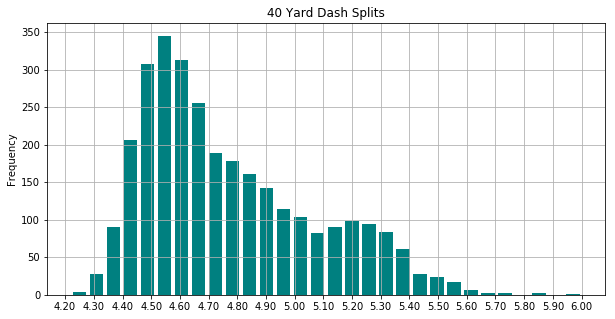

In [32]:
# Plot population of 40 yar dash splits in a histogram
ax = hist_df.plot.hist(grid=True, bins=30, rwidth=0.8,
                       legend=False, color='#008080',
                       title='40 Yard Dash Splits',
                       xticks=xticks_list, figsize=(10, 5))
ax.xaxis.set_ticklabels(xticks_labels);

In [79]:
dash_df.to_csv('C:\\Users\\David\\Desktop\\Substack\\forty_yard_dash_data.csv')